In [3]:
import numpy as np
from matplotlib import pyplot as plt
import arviz as az
from pymob import Config
from pymob.sim.config import Param
from pymob.sim.plot import SimulationPlot

In [4]:
# load case study
from hierarchical_molecular_tktd.sim import (
    NomixHierarchicalSimulation, 
    plot_y0
)

from hierarchical_molecular_tktd.prob import (
    conditional_survival_error_model, 
)

In [5]:
config = Config("../scenarios/hierarchical_cext_nested_sigma_hyperprior/settings.cfg")
config.case_study.package = "../.."
config.case_study.data_path = "../../tktd_rna_pulse/data"
sim = NomixHierarchicalSimulation(config)
sim.setup()
sim.dispatch_constructor()

/home/flo-schu/projects/pymob/pymob/sim/parameters.py:126: UserWarning: The distribution 'deterministic' is not part of the scipy distributions implemented in pymob. This can lead to inconsistent behavior. It is recommended to use the scipy distribution protocol where possible. https://docs.scipy.org/doc/scipy/reference/stats.html It may also be possible that your distribution has not yet been introduced into the pymob package 
  warnings.warn(


MinMaxScaler(variable=cint, min=1e-08, max=6582.763087754983)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)
Results directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/results/hierarchical_cext_nested_sigma_hyperprior'.
Scenario directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/scenarios/hierarchical_cext_nested_sigma_hyperprior'.


## Hierarchical error structure for $C_{ext,0}$ ($y_0$) nested in experiments

We need a hpyerprior for experimental deviations

In [6]:
# create a parameter with the new dimension and add it at first position to the model_parameters
error_scale = Param(prior="halfnorm(scale=1)", hyper=True, free=True)
error_scale_sigma = Param(prior="halfnorm(scale=1)", hyper=True, free=True)
sigma_experiment = Param(dims=("experiment_id",), prior="lognorm(scale=error_scale, s=error_scale_sigma)", hyper=False, free=True)
cext_y0 = Param(dims=("id",), prior=f"deterministic(value=cext_y0*sigma_experiment[experiment_id_index])", free=True)

sim.config.model_parameters.error_scale = error_scale
sim.config.model_parameters.error_scale_sigma = error_scale_sigma
sim.config.model_parameters.cext_y0 = cext_y0
sim.config.model_parameters.sigma_experiment = sigma_experiment
sim.config.model_parameters.reorder(["error_scale", "error_scale_sigma", "sigma_experiment", "cext_y0"])
print(f"'sigma_experiment' parameter shape: {sim.parameter_shapes['sigma_experiment']}")
print(f"'cext_y0' parameter shape: {sim.parameter_shapes['cext_y0']}")


'sigma_experiment' parameter shape: (42,)
'cext_y0' parameter shape: (314,)


/home/flo-schu/projects/pymob/pymob/sim/parameters.py:126: UserWarning: The distribution 'deterministic' is not part of the scipy distributions implemented in pymob. This can lead to inconsistent behavior. It is recommended to use the scipy distribution protocol where possible. https://docs.scipy.org/doc/scipy/reference/stats.html It may also be possible that your distribution has not yet been introduced into the pymob package 
  warnings.warn(


In [7]:
sim.use_numpyro_backend(error_model=conditional_survival_error_model, only_prior=False)

Jax 64 bit mode: False
Absolute tolerance: 1e-06


'../../hierarchical_molecular_tktd/results/hierarchical_cext_nested_sigma_hyperprior/y0_nominal_prior.png'

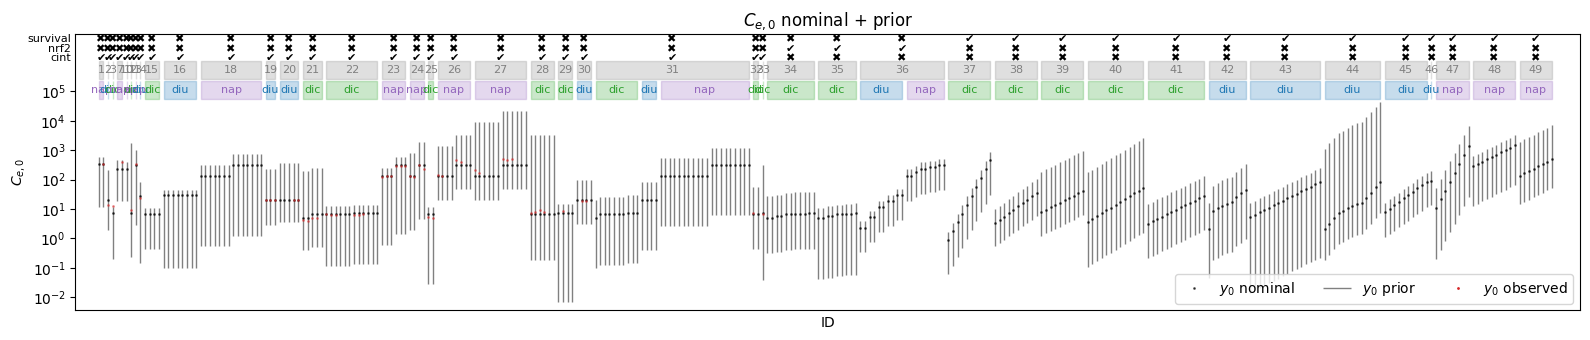

In [8]:
idata = sim.inferer.prior_predictions(n=10)
plot_y0(
    sim=sim, idata=idata, parameter="cext", idata_group="prior", 
    levels=["experiment_id", "substance",], 
    colors={"substance": ["tab:green", "tab:blue", "tab:purple"]},
    show_observed=True,
    show_measured_endpoints=True,
)

As opposed to the previous prior specification, we now set the starting value $y_0$ deterministically and only vary the error of the experiment (which is multiplicative). Note that any **non-centered appearing priors are only due to sampling only 10 prior draws**. This means this prior specification is a bit more restrictive, because it assumes that error on the starting values depend on the experiment, and not on each individual treatment.

                     Trace Shapes:         
                      Param Sites:         
                     Sample Sites:         
      error_scale_normal_base dist        |
                             value        |
error_scale_sigma_normal_base dist        |
                             value        |
 sigma_experiment_normal_base dist     42 |
                             value     42 |
    k_i_substance_normal_base dist      3 |
                             value      3 |
   r_rt_substance_normal_base dist      3 |
                             value      3 |
   r_rd_substance_normal_base dist      3 |
                             value      3 |
   v_rt_substance_normal_base dist      3 |
                             value      3 |
   z_ci_substance_normal_base dist      3 |
                             value      3 |
    k_p_substance_normal_base dist      3 |
                             value      3 |
    k_m_substance_normal_base dist      3 |
                             val

100%|██████████| 1000/1000 [01:04<00:00, 15.55it/s, init loss: 218362.4531, avg. loss [951-1000]: 1277.4929]
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


                              mean     sd  hdi_3%  hdi_97%  mcse_mean  \
cext_y0[101_0]               4.475  0.425   3.710    5.287      0.010   
cext_y0[101_1]               4.475  0.425   3.710    5.287      0.010   
cext_y0[106_0]               9.868  0.937   8.182   11.658      0.022   
cext_y0[106_1]               9.868  0.937   8.182   11.658      0.022   
cext_y0[112_0]              22.413  2.129  18.583   26.480      0.050   
...                            ...    ...     ...      ...        ...   
z_ci_substance[diclofenac]   0.176  0.008   0.161    0.190      0.000   
z_ci_substance[naproxen]     0.706  0.028   0.655    0.759      0.001   
z_substance[diuron]          1.773  0.080   1.625    1.924      0.002   
z_substance[diclofenac]      1.710  0.045   1.631    1.796      0.001   
z_substance[naproxen]        2.647  0.096   2.456    2.813      0.002   

                            mcse_sd  ess_bulk  ess_tail  r_hat  
cext_y0[101_0]                0.007    1824.0    1962.0   

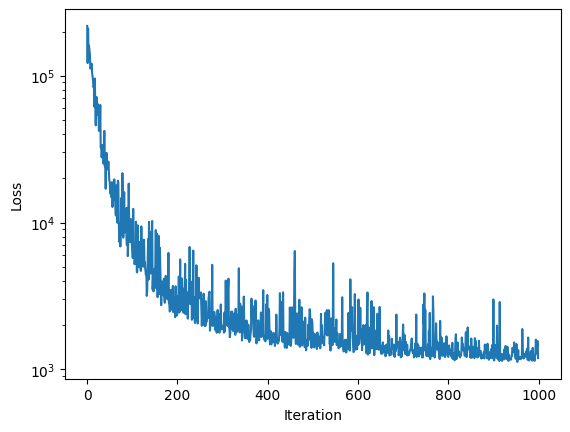

In [9]:
sim.config.inference_numpyro.kernel = "svi"
sim.config.inference.n_predictions = 100
sim.config.inference_numpyro.init_strategy = "init_to_uniform"
sim.config.inference_numpyro.svi_iterations = 1000
sim.config.inference_numpyro.svi_learning_rate = 0.01
sim.config.simulation.seed=4
sim.dispatch_constructor()

if True:
    sim.inferer.run()
    sim.inferer.store_results(output=f"{sim.output_path}/numpyro_svi_posterior.nc")
    idata = sim.inferer.idata
else:
    idata = sim.inferer.load_results(file="numpyro_svi_posterior.nc")

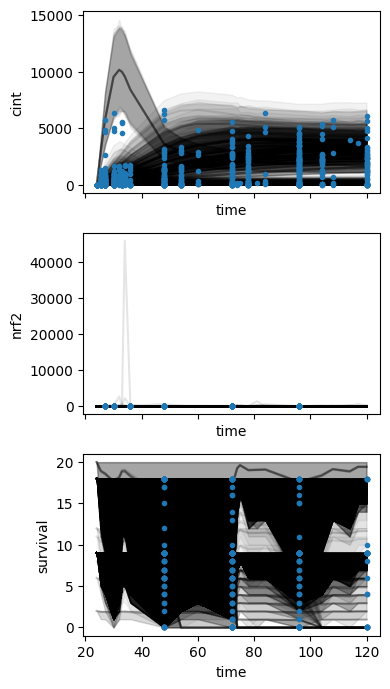

In [10]:
simplot = SimulationPlot(
    observations=sim.observations,
    idata=sim.inferer.idata,
    coordinates=sim.dimension_coords,
    config=sim.config,
    idata_groups=["posterior_predictive"],
)   
simplot.plot_data_variables()

'../../hierarchical_molecular_tktd/results/hierarchical_cext_nested_sigma_hyperprior/y0_nominal_posterior.png'

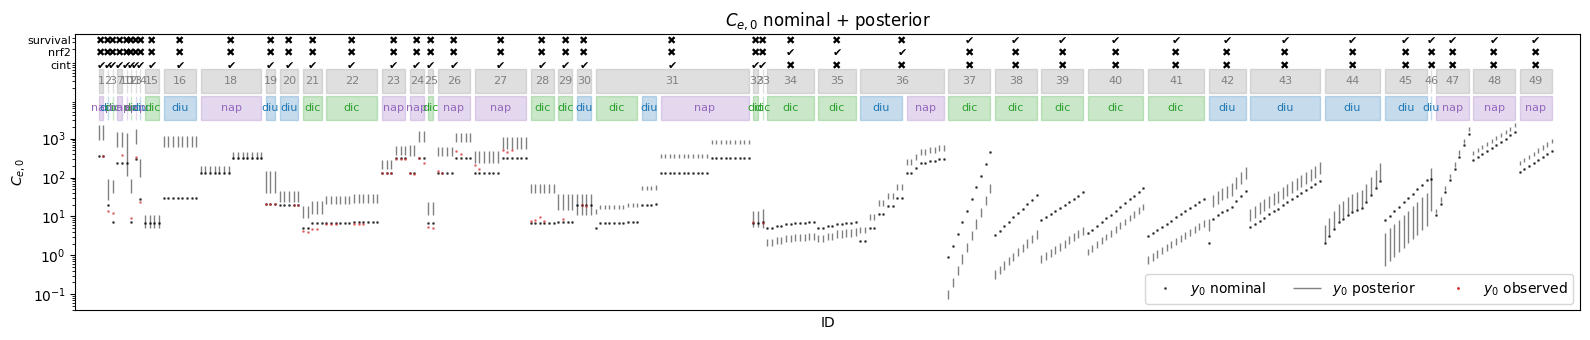

In [11]:
plot_y0(
    sim=sim, idata=idata, parameter="cext", idata_group="posterior", 
    levels=["experiment_id", "substance",], 
    colors={"substance": ["tab:green", "tab:blue", "tab:purple"]},
    show_observed=True,
    show_measured_endpoints=True,
)

Compared to the deviation of the true concentrations from the measured concentrations, the results from the hyperprior model look very good, there is considerably leass variation for most experiments.

<Axes: title={'center': 'error_scale_sigma'}>

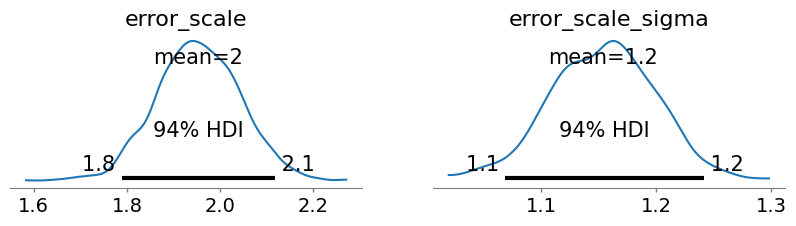

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,2))
az.plot_posterior(sim.inferer.idata.posterior.error_scale, ax=ax1)
az.plot_posterior(sim.inferer.idata.posterior.error_scale_sigma, ax=ax2)

On average the true concentrations are a factor of 2.1 larger than the nominal concentrations. Generally few experiments have higher true concentrations than nominal concentrations which is expected. It would be interesting to investigate if this depends on the substance. One could also **interpret the fitted y0 concentration as the concentration available for uptake**. Interestingly, in later experiments (from experiment 34 onwards. Diclofenac "true" concentrations are consistently fitted lower than the nominal concentrations.)

In [13]:
sim.seed=2
sim.config.inference.n_predictions = 1000
sim.coordinates["time"] = np.linspace(24,120,200)
sim.dispatch_constructor()
sim._plot.pretty_posterior_plot_multisubstance(sim)
sim.reset_coordinate("time")

PRETTY PLOT: starting...


Posterior predictions:   2%|▏         | 19/1000 [00:02<01:01, 16.06it/s]

Posterior predictions: 100%|██████████| 1000/1000 [00:31<00:00, 31.40it/s]


PRETTY PLOT: make predictions for Diuron in bin (1/5)
PRETTY PLOT: make predictions for Diuron in bin (2/5)
PRETTY PLOT: make predictions for Diuron in bin (3/5)
PRETTY PLOT: make predictions for Diuron in bin (4/5)
PRETTY PLOT: make predictions for Diuron in bin (5/5)
PRETTY PLOT: make predictions for Diclofenac in bin (1/4)
PRETTY PLOT: make predictions for Diclofenac in bin (2/4)
PRETTY PLOT: make predictions for Diclofenac in bin (3/4)
PRETTY PLOT: make predictions for Diclofenac in bin (4/4)
PRETTY PLOT: make predictions for Naproxen in bin (1/6)
PRETTY PLOT: make predictions for Naproxen in bin (2/6)
PRETTY PLOT: make predictions for Naproxen in bin (3/6)
PRETTY PLOT: make predictions for Naproxen in bin (4/6)
PRETTY PLOT: make predictions for Naproxen in bin (5/6)
PRETTY PLOT: make predictions for Naproxen in bin (6/6)


![combined_pps_figure_diclofenac.png](../results/hierarchical_cext_nested_sigma_hyperprior/combined_pps_figure_diclofenac.png)
![combined_pps_figure_diuron.png](../results/hierarchical_cext_nested_sigma_hyperprior/combined_pps_figure_diuron.png)
![combined_pps_figure_naproxen.png](../results/hierarchical_cext_nested_sigma_hyperprior/combined_pps_figure_naproxen.png)

We see that some data can be fitted much better, with more realistic dynamic. Also the error estimates for the trajectories became much narrower. Previously these error estimates for the intercepts were massive. This is an improvement. Of course the model is not perfect. But it seems that we are approaching reality much better.

<Axes: title={'center': 'sigma_nrf2'}>

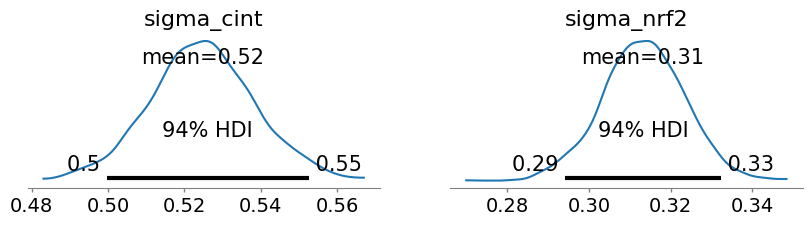

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,2))
az.plot_posterior(sim.inferer.idata.posterior.sigma_cint, ax=ax1)
az.plot_posterior(sim.inferer.idata.posterior.sigma_nrf2, ax=ax2)

One overall sigma parameter for internal concentrations and nrf2 accross all substances makes a better impression. This is the residual multiplicative error (sigma on a normal distribution)

In [15]:
sim.config.case_study.scenario = "hierarchical_cext_nested_sigma_hyperprior_per_substance"
sim.config.create_directory("scenario", force=True)
sim.config.save(force=True)

Scenario directory created at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/scenarios/hierarchical_cext_nested_sigma_hyperprior_per_substance'.
